In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import \
    classification_report, roc_auc_score, roc_curve, auc

In [2]:
df = pd.read_csv('data/CC GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [4]:
df.isnull().sum().sum()

314

In [5]:
df['CREDIT_LIMIT']=df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())
df['MINIMUM_PAYMENTS']=df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean())

In [6]:
df['MINIMUM_PAYMENTS'].mean()

864.2065423050827

In [7]:
df=df.drop(['CUST_ID'], axis= 1)

In [8]:
X=df

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler() 
scaler.fit(X) 
X_norm = scaler.transform(X) 
X_norm[0][0]

-0.7319893664465486

In [12]:
from sklearn.cluster import KMeans
import seaborn as sns

<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

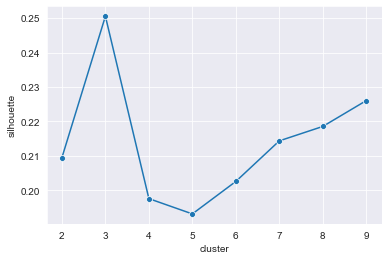

In [13]:
# импортируем метрику силуэт
from sklearn.metrics import silhouette_score

# напишем функцию, как и при подсчете метода локтя
def get_silhouette(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X_norm))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

In [14]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_norm)

In [15]:
df.loc[:, 'label'] = kmeans.labels_
df.label.value_counts()

0    6118
1    1597
2    1235
Name: label, dtype: int64

In [17]:
from sklearn.cluster import DBSCAN

Попробуем применить DBSCAN. Для начала реализуйте его с параметрами по умолчанию.

Сколько кластеров было выделено?

In [20]:
db = DBSCAN()
db.fit(X_norm)
clusters = db.labels_
len(set(clusters)) - (1 if -1 in clusters else 0)

38

В предыдущем задании получилось очень много кластеров. Возможно, это случилось потому, что мы взяли параметры по умолчанию, а результат алгоритма DBSCAN, как вы помните, очень чувствителен к ним.

Давайте попробуем с помощью цикла перебрать параметр eps по значениям, заданным как np.arange(0.1,3,0.2), а параметр min_samples — по значениям, заданным как range(1,20,4). Найдите комбинацию, которая даёт максимальное значение коэффициента силуэта.

In [21]:
siliuette_list_dbscan = []
 
for eps in np.arange(0.1,3,0.2):
    for min_sample in range(1,20,4):
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(X_norm)
        sil_score = silhouette_score(X_norm, dbscan.labels_, metric='euclidean')
        siliuette_list_dbscan.append((eps, min_sample, sil_score, len(set(dbscan.labels_))) )
df_dbscan = pd.DataFrame(siliuette_list_dbscan, columns=['eps', 'min_samples', 'sil_score', 'number_of_clusters'])
df_dbscan.sort_values(by = 'sil_score')

,eps,min_samples,sil_score,number_of_clusters
11,0.5,5,-0.443701,39
16,0.7,5,-0.438837,29
6,0.3,5,-0.424475,42
7,0.3,9,-0.404209,15
30,1.3,1,-0.399305,1536
...,...,...,...,...
74,2.9,17,0.591924,2
66,2.7,5,0.592182,2
73,2.9,13,0.595399,2
72,2.9,9,0.603811,2


Теперь давайте реализуем агломеративную иерархическую кластеризацию. Переберите количество кластеров в диапазоне от 3 до 9 включительно и найдите то их число, которое будет давать максимальный коэффициент силуэта.

In [22]:
from sklearn.cluster import AgglomerativeClustering

In [23]:
siliuette_list_hierarchical = []
 
for cluster in range(3,10,1):
        agglomerative = AgglomerativeClustering(affinity='euclidean',n_clusters=cluster).fit_predict(X_norm)
        sil_score = silhouette_score(X_norm, agglomerative, metric='euclidean')
        siliuette_list_hierarchical.append((cluster, sil_score,len(set(agglomerative)) ) )
        
df_hierarchical = pd.DataFrame(siliuette_list_hierarchical, columns=['cluster', 'sil_score','number_of_clusters'])
 
 
df_hierarchical.sort_values(by = 'sil_score')

,cluster,sil_score,number_of_clusters
5,8,0.152035,8
6,9,0.153719,9
1,4,0.154709,4
4,7,0.156415,7
2,5,0.158069,5
0,3,0.173110,3
3,6,0.173356,6


Сколько будет наблюдений в самом многочисленном классе, если мы обучим на наших данных модель агломеративной иерархической кластеризации с количеством кластеров, полученным в предыдущем задании?

In [24]:
model = AgglomerativeClustering(affinity='euclidean', n_clusters=6).fit(X_norm)
df['cluster_id'] = model.labels_
df['cluster_id'].value_counts()

0    3946
1    2931
2     864
5     722
3     464
4      23
Name: cluster_id, dtype: int64

Давайте визуализируем результаты кластеризации k-means, отобразив два признака — количество покупок и кредитный лимит:

In [25]:
import matplotlib.pyplot as plt

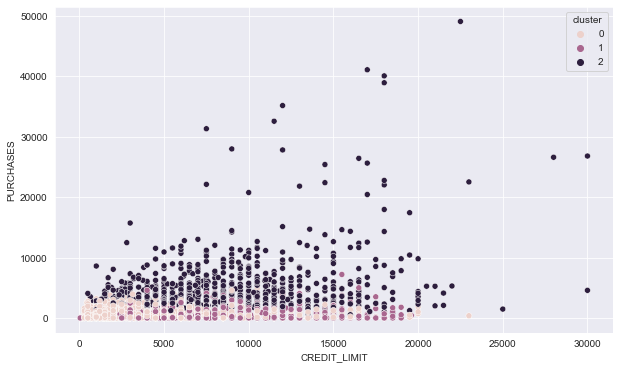

In [26]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_norm)
df['cluster'] = kmeans.labels_
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster')
plt.show()